# Logistic Regression With Mini-Batch Gradient Descent

### Preparation

In [1]:
# Import the libraries we need for this lab

# Allows us to use arrays to manipulate and store data
import numpy as np
# Used to graph data and loss curves
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# PyTorch Library
import torch
# Used to help create the dataset and perform mini-batch
from torch.utils.data import Dataset, DataLoader
# PyTorch Neural Network
import torch.nn as nn

In [2]:
# Create class for plotting and the function for plotting

class plot_error_surfaces(object):
    
    # Construstor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                yhat= 1 / (1 + np.exp(-1*(w2*self.x+b2)))
                Z[count1,count2]=-1*np.mean(self.y*np.log(yhat+1e-16) +(1-self.y)*np.log(1-yhat+1e-16))
                count2 += 1   
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
     # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)
    
    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x[self.y==0], self.y[self.y==0], 'ro', label="training points")
        plt.plot(self.x[self.y==1], self.y[self.y==1]-1, 'o', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        
# Plot the diagram

def PlotStuff(X, Y, model, epoch, leg=True):
    
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg == True:
        plt.legend()
    else:
        pass           

In [3]:
# Setting the seed will allow us to control randomness and give us reproducibility
torch.manual_seed(0)

### Load Data

In [4]:
# Create the custom Data class which inherits Dataset
class Data(Dataset):
    
    # Constructor
    def __init__(self):
        # Create X values from -1 to 1 with step .1
        self.x = torch.arange(-1, 1, 0.1).view(-1,1)
        # Create Y values all set to 0
        self.y = torch.zeros(self.x.shape[0], 1)
        # Set the X values above 0.2 to 1
        self.y[self.x[:, 0] > 0.2] = 1
        # Set the .len attribute because we need to override the __len__ method
        self.len = self.x.shape[0]
        
    # Getter that returns the data at the given index
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    # Get length of the dataset
    def __len__(self):
        return self.len

In [5]:
# Create Data object
data_set = Data()

In [6]:
data_set.x

tensor([[-1.0000e+00],
        [-9.0000e-01],
        [-8.0000e-01],
        [-7.0000e-01],
        [-6.0000e-01],
        [-5.0000e-01],
        [-4.0000e-01],
        [-3.0000e-01],
        [-2.0000e-01],
        [-1.0000e-01],
        [-2.9802e-09],
        [ 1.0000e-01],
        [ 2.0000e-01],
        [ 3.0000e-01],
        [ 4.0000e-01],
        [ 5.0000e-01],
        [ 6.0000e-01],
        [ 7.0000e-01],
        [ 8.0000e-01],
        [ 9.0000e-01]])

In [7]:
data_set.y

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [8]:
len(data_set)

20

In [9]:
x,y = data_set[1]
print("x = {}, y = {}".format(x,y))

x = tensor([-0.9000]), y = tensor([0.])


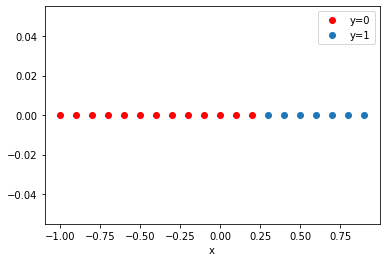

In [10]:
plt.plot(data_set.x[data_set.y == 0], data_set.y[data_set.y == 0], 'ro', label='y=0')
plt.plot(data_set.x[data_set.y == 1], data_set.y[data_set.y == 1]-1, 'o', label='y=1')
plt.xlabel('x')
plt.legend()

### Create the Model and Total Loss Function (Cost)

In [11]:
# Create logistic_regression class that inherits nn.Module which is the base class for all neural networks
class logistic_regression(nn.Module):
    
    # Constructor
    def __init__(self, n_inputs):
        super(logistic_regression, self).__init__()
        # Single layer of Logistic Regression with number of inputs being n_inputs and there being 1 output
        self.linear = nn.Linear(n_inputs, 1)
        
    # Prediction
    def forward(self, x):
        # Using the input x value puts it through the single layer defined above then puts the output through the sigmoid function and returns the result
        yhat = torch.sigmoid(self.linear(x))
        return yhat

In [12]:
x,y = data_set[0]
len(x)

1

In [13]:
# Create the logistic_regression result

model = logistic_regression(1)

In [14]:
x = torch.tensor([-1.0])

sigma = model(x)
sigma

tensor([0.6327], grad_fn=<SigmoidBackward0>)

In [15]:
x,y = data_set[2]

sigma = model(x)
sigma

tensor([0.6324], grad_fn=<SigmoidBackward0>)

<Figure size 432x288 with 0 Axes>

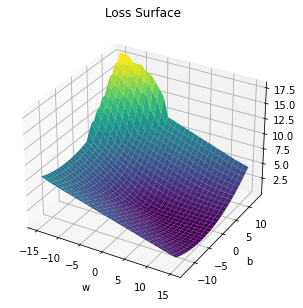

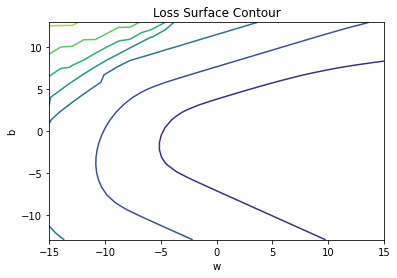

In [16]:
# Create the plot_error_surfaces object

# 15 is the range of w
# 13 is the range of b
# data_set[:][0] are all the X values
# data_set[:][1] are all the Y values

get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1])

In [17]:
criterion = nn.BCELoss()

In [18]:
x, y = data_set[0]
print("x = {}, y = {}".format(x,y))

x = tensor([-1.]), y = tensor([0.])


In [19]:
sigma = model(x)
sigma

tensor([0.6327], grad_fn=<SigmoidBackward0>)

In [20]:
loss = criterion(sigma, y)
loss

tensor(1.0016, grad_fn=<BinaryCrossEntropyBackward0>)

### Setting the Batch Size using a Data Loader

In [21]:
batch_size=10

In [22]:
trainloader = DataLoader(dataset = data_set, batch_size=10)

In [23]:
dataset_iter = iter(trainloader)

In [24]:
X,y = next(dataset_iter)

In [25]:
X

tensor([[-1.0000],
        [-0.9000],
        [-0.8000],
        [-0.7000],
        [-0.6000],
        [-0.5000],
        [-0.4000],
        [-0.3000],
        [-0.2000],
        [-0.1000]])

### Setting the Learning Rate

In [26]:
learning_rate = 0.1

In [27]:
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

### Train the Model via Mini-Batch Gradient Descent

<Figure size 432x288 with 0 Axes>

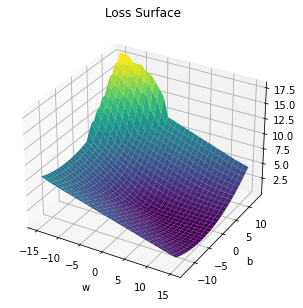

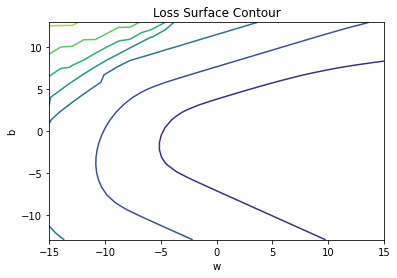

In [28]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

#### Train the Model

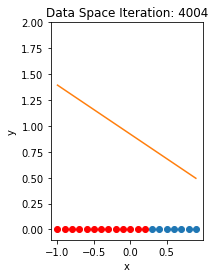

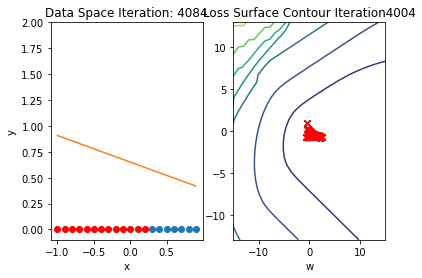

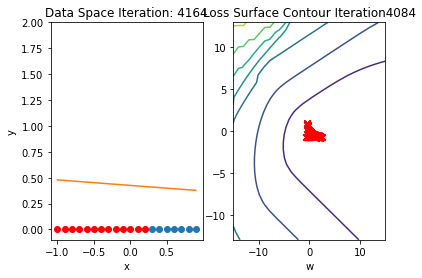

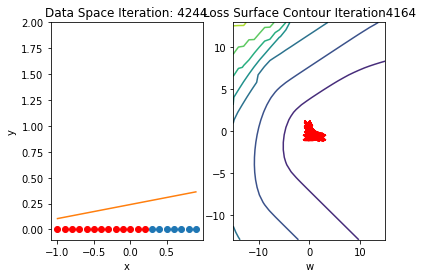

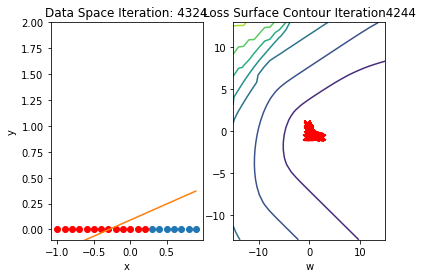

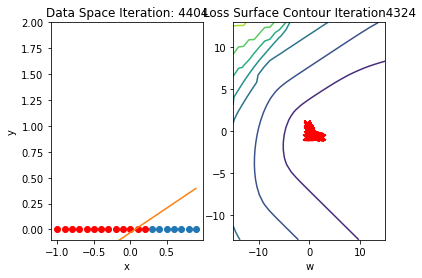

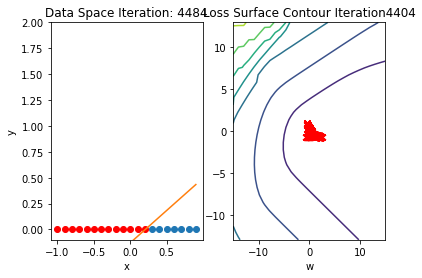

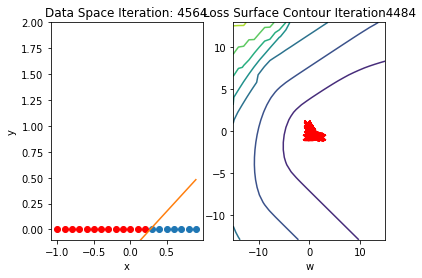

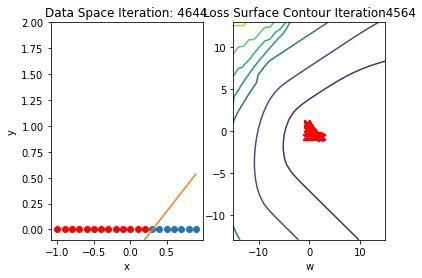

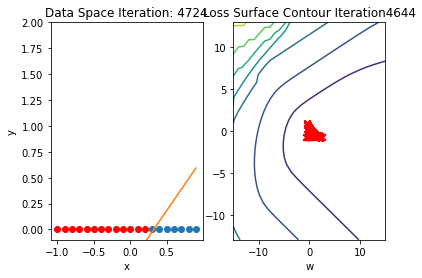

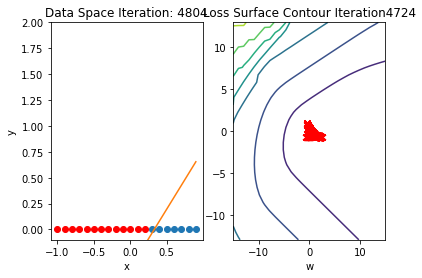

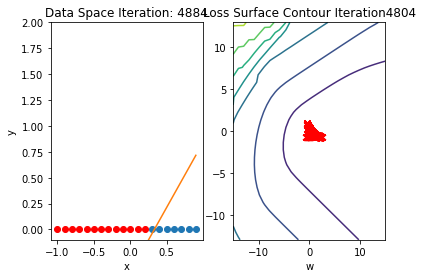

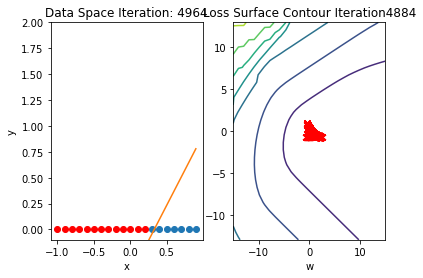

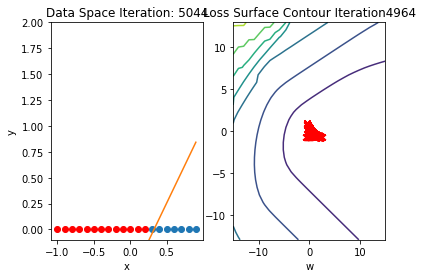

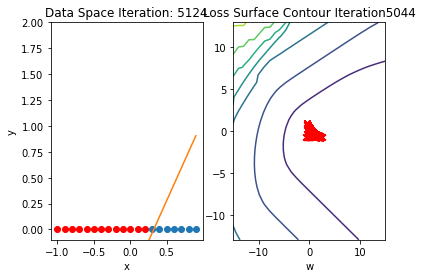

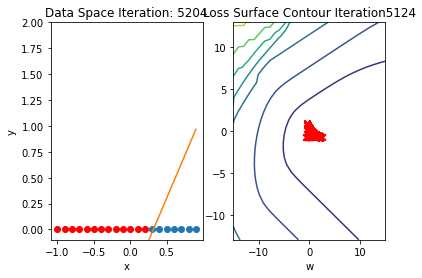

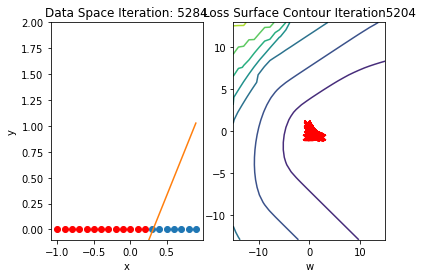

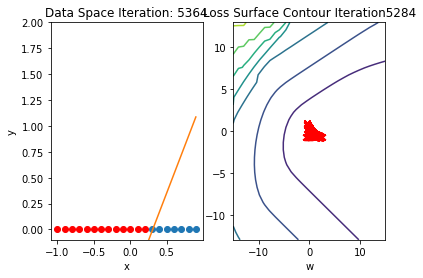

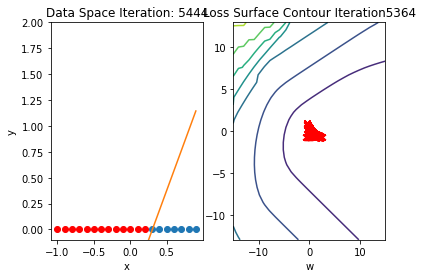

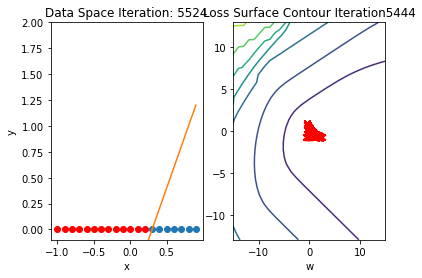

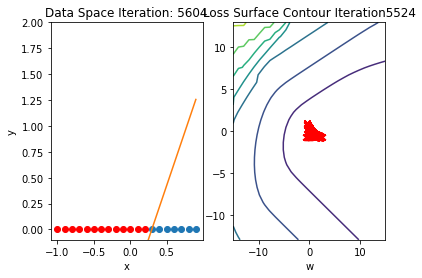

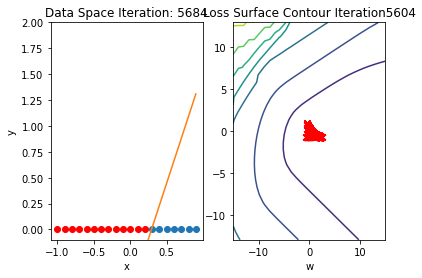

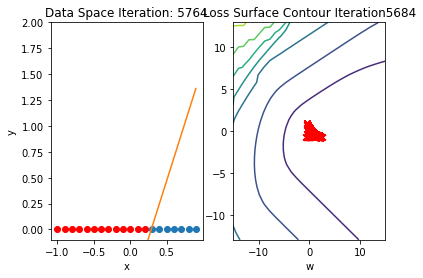

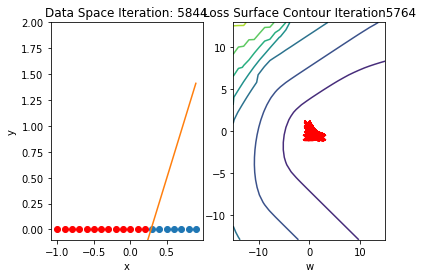

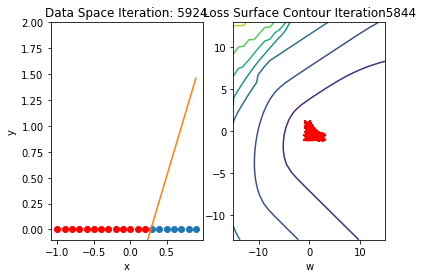

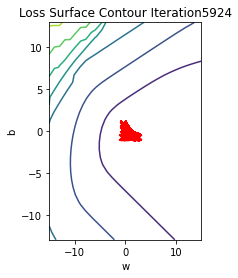

In [42]:
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion which will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 5
trainloader = DataLoader(dataset=data_set, batch_size=5)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=.01)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs = 500
# This will store the loss over iterations so we can plot it at the end
loss_values = []

# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.detach().numpy())
        # Saves the loss of the iteration
        loss_values.append(loss.detach().numpy())
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()

In [45]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print('w = ', w, 'b = ', b)

w =  tensor([2.4227]) b =  tensor(-0.6749)


In [46]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct += 1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print('Accuracy: ', correct/len(data_set)*100, "%")

Accuracy:  100.0 %


Text(0, 0.5, 'Cost')

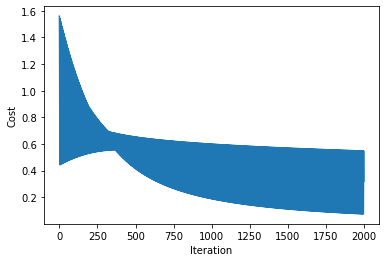

In [47]:
plt.plot(loss_values)
plt.xlabel('Iteration')
plt.ylabel('Cost')

### Stochastic Gradient Descent

<Figure size 432x288 with 0 Axes>

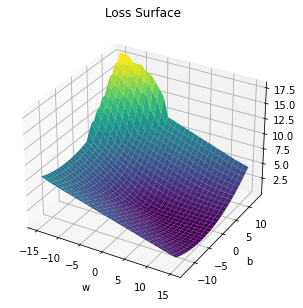

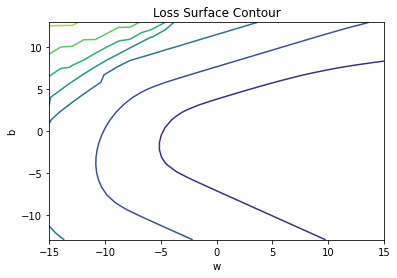

In [48]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

#### Train the Model

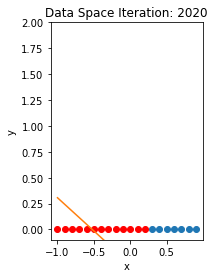

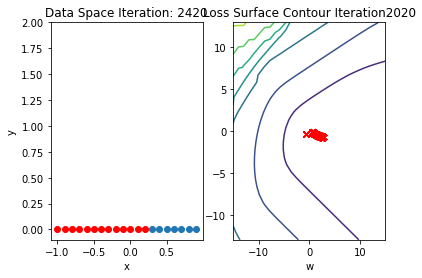

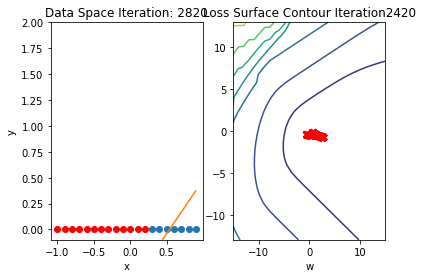

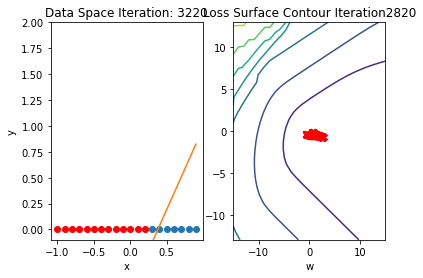

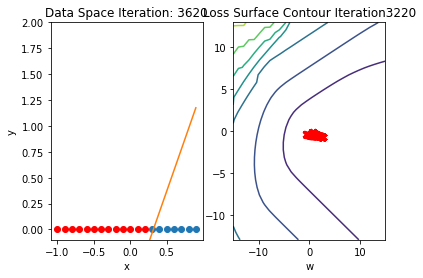

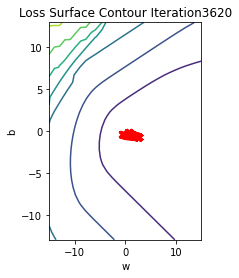

In [53]:
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion which will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 1
trainloader = DataLoader(dataset = data_set, batch_size = 1)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = .01)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs=100
# This will store the loss over iterations so we can plot it at the end
loss_values = []

# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.detach().numpy())
        # Saves the loss of the iteration
        loss_values.append(loss.detach().numpy())
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()

In [54]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([2.3599]) b =  tensor(-0.6785)


In [55]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


Text(0, 0.5, 'Cost')

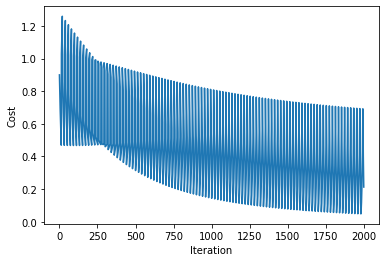

In [56]:
plt.plot(loss_values)
plt.xlabel("Iteration")
plt.ylabel("Cost")

### High Learning Rate

<Figure size 432x288 with 0 Axes>

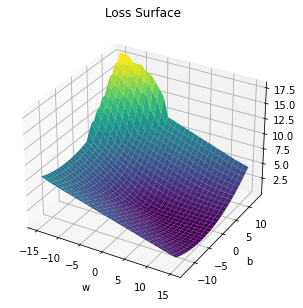

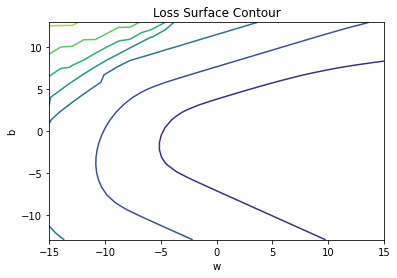

In [57]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

### Train the Model

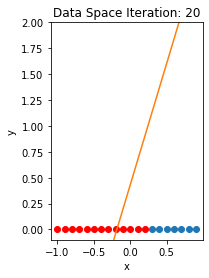

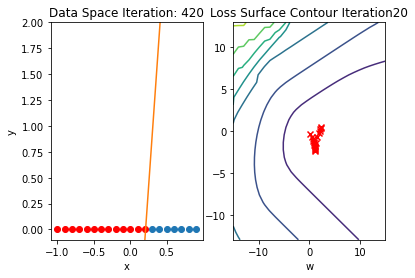

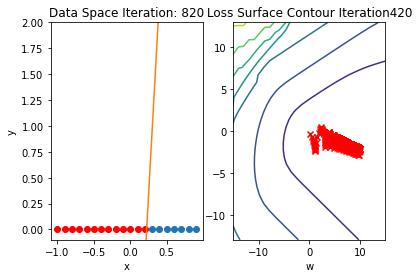

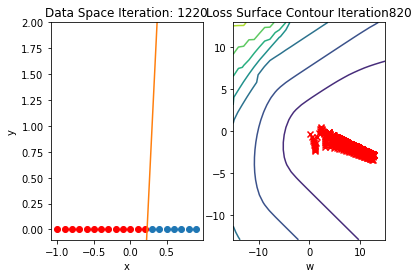

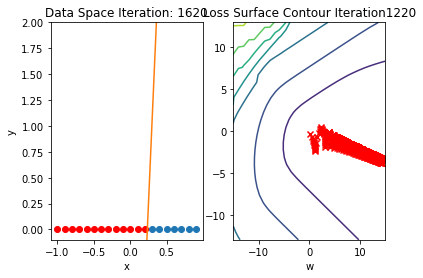

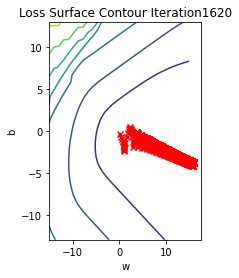

In [58]:
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion that will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 1
trainloader = DataLoader(dataset = data_set, batch_size = 1)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs=100
# This will store the loss over iterations so we can plot it at the end
loss_values = []

# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.detach().numpy())
        # Saves the loss of the iteration
        loss_values.append(loss.detach().numpy())
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()

In [59]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([17.3013]) b =  tensor(-4.0849)


In [60]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


Text(0, 0.5, 'Cost')

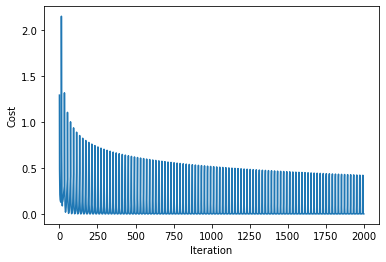

In [61]:
plt.plot(loss_values)
plt.xlabel("Iteration")
plt.ylabel("Cost")

### Question

<Figure size 432x288 with 0 Axes>

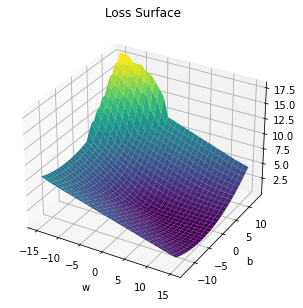

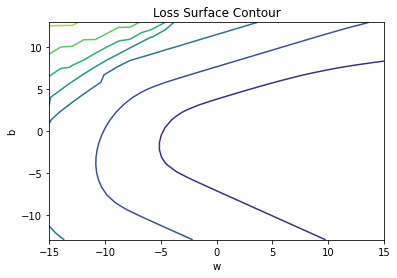

In [62]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

### Train the Model

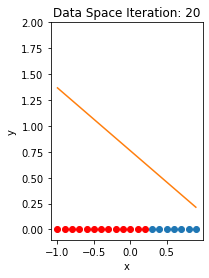

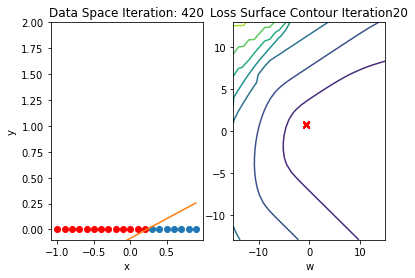

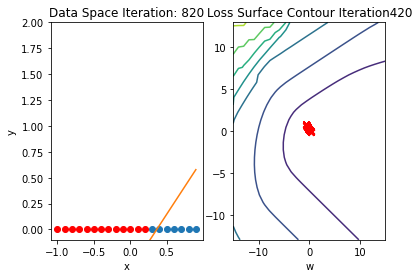

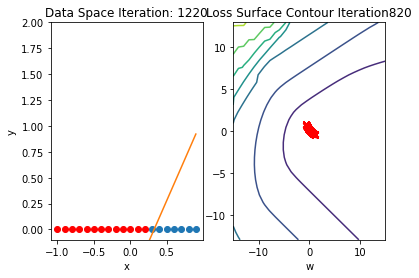

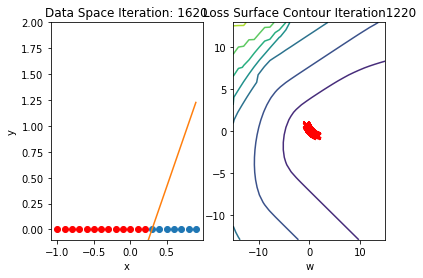

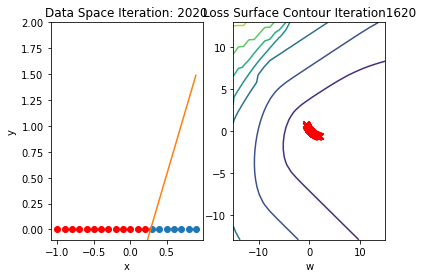

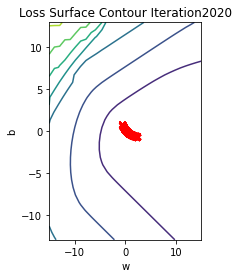

In [63]:
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion which will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 1
trainloader = DataLoader(dataset = data_set, batch_size = 1)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = .01)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs= 120
# This will store the loss over iterations so we can plot it at the end
loss_values = []

# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.detach().numpy())
        # Saves the loss of the iteration
        loss_values.append(loss.detach().numpy())
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()

In [64]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([2.6865]) b =  tensor(-0.7156)


In [65]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


Text(0, 0.5, 'Cost')

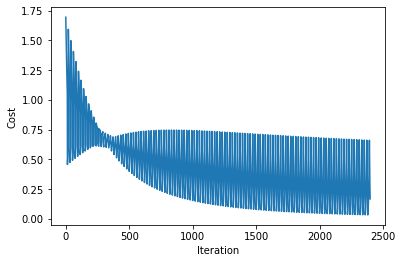

In [66]:
plt.plot(loss_values)
plt.xlabel("Iteration")
plt.ylabel("Cost")